In [1]:
!pip install cartopy

In [2]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore') 


import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import zipfile
import datetime as dt
import cartopy.crs as ccrs  ##  Cartopy의 좌표 참조 시스템을 ccrs로 가져옴
import cartopy.feature as cfeature  ## Cartopy의 지형 및 해양 기능을 cfeature로 가져옴
from scipy.spatial import distance
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime, date, time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

plt.rc('font', family='malgun gothic')    # 한글처리
plt.rcParams['axes.unicode_minus']=False  # '- 표시

In [6]:
birdata = pd.read_csv('Data/bird_tracking.csv')
birdata.columns

Index(['altitude', 'date_time', 'device_info_serial', 'direction', 'latitude',
       'longitude', 'speed_2d', 'bird_name'],
      dtype='object')

In [7]:
birdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61931 entries, 0 to 61930
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   altitude            61931 non-null  int64  
 1   date_time           61931 non-null  object 
 2   device_info_serial  61931 non-null  int64  
 3   direction           0 non-null      float64
 4   latitude            61931 non-null  float64
 5   longitude           61931 non-null  float64
 6   speed_2d            61488 non-null  float64
 7   bird_name           61931 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 3.8+ MB


In [8]:
birdata.date_time[0:3]

0    2013-08-15 00:18:08+00
1    2013-08-15 00:48:07+00
2    2013-08-15 01:17:58+00
Name: date_time, dtype: object

In [9]:
## Eric의 비행시작과 마지막 일자

ix = birdata.bird_name == 'Eric'
date = birdata.date_time[ix]
print(date[:1])
print(date[-1:])

0    2013-08-15 00:18:08+00
Name: date_time, dtype: object
19797    2014-04-30 23:51:29+00
Name: date_time, dtype: object


In [12]:
date_str = birdata.date_time[0]
dt.datetime.strptime(date_str[:-3], '%Y-%m-%d %H:%M:%S')                     
# string pars time 
# (문자열을 날짜와 시간으로 parsing, 맨뒤의 세글짜는 뺌)

datetime.datetime(2013, 8, 15, 0, 18, 8)

In [13]:
a = dt.datetime.strptime(date_str[:-3], '%Y-%m-%d %H:%M:%S')
print(a)

2013-08-15 00:18:08


In [19]:
# 모든행의 datetime을 변경

timestamps = []
for k in range(len(birdata)):
    timestamps.append(dt.datetime.strptime(birdata.date_time.iloc[k][:-3],'%Y-%m-%d %H:%M:%S'))
timestamps

[datetime.datetime(2013, 8, 15, 0, 18, 8),
 datetime.datetime(2013, 8, 15, 0, 48, 7),
 datetime.datetime(2013, 8, 15, 1, 17, 58),
 datetime.datetime(2013, 8, 15, 1, 47, 51),
 datetime.datetime(2013, 8, 15, 2, 17, 42),
 datetime.datetime(2013, 8, 15, 2, 47, 38),
 datetime.datetime(2013, 8, 15, 3, 2, 33),
 datetime.datetime(2013, 8, 15, 3, 17, 27),
 datetime.datetime(2013, 8, 15, 3, 32, 35),
 datetime.datetime(2013, 8, 15, 3, 47, 48),
 datetime.datetime(2013, 8, 15, 4, 3, 39),
 datetime.datetime(2013, 8, 15, 4, 18, 40),
 datetime.datetime(2013, 8, 15, 4, 33, 53),
 datetime.datetime(2013, 8, 15, 4, 49, 6),
 datetime.datetime(2013, 8, 15, 5, 4, 45),
 datetime.datetime(2013, 8, 15, 5, 20, 9),
 datetime.datetime(2013, 8, 15, 5, 35, 4),
 datetime.datetime(2013, 8, 15, 5, 49, 58),
 datetime.datetime(2013, 8, 15, 6, 4, 56),
 datetime.datetime(2013, 8, 15, 6, 19, 54),
 datetime.datetime(2013, 8, 15, 6, 34, 50),
 datetime.datetime(2013, 8, 15, 6, 49, 43),
 datetime.datetime(2013, 8, 15, 7, 4, 40)

In [21]:
bird_names = pd.unique(birdata.bird_name)
print(bird_names)

['Eric' 'Nico' 'Sanne']


In [22]:
# 모든행의 datetime을 변경

timestamps = []
for k in range(len(birdata)):
    timestamps.append(dt.datetime.strptime(birdata.date_time.iloc[k][:-3],'%Y-%m-%d %H:%M:%S'))

birdata['timestamp'] = pd.Series(timestamps, index = birdata.index)
birdata.head()

,altitude,date_time,device_info_serial,direction,latitude,longitude,speed_2d,bird_name,timestamp
0,71,2013-08-15 00:18:08+00,851,NaN,49.419860,2.120733,0.191484,Eric,2013-08-15 00:18:08
1,68,2013-08-15 00:48:07+00,851,NaN,49.419880,2.120746,2.739698,Eric,2013-08-15 00:48:07
2,68,2013-08-15 01:17:58+00,851,NaN,49.420310,2.120885,0.360099,Eric,2013-08-15 01:17:58
3,73,2013-08-15 01:47:51+00,851,NaN,49.420359,2.120859,0.039658,Eric,2013-08-15 01:47:51
4,69,2013-08-15 02:17:42+00,851,NaN,49.420331,2.120887,0.107988,Eric,2013-08-15 02:17:42


In [25]:
times = birdata.timestamp[birdata.bird_name == 'Eric']
elapsed = [time - times[0] for time in times]
# elapsed # 모두 보기
elapsed[100] # 100번째 시간까지의 시간차이

# Eric의 시작부터 각 Point 까지의 경과시간 (시작Data 외의 차이)

Timedelta('1 days 05:24:41')

Text(0, 0.5, 'Elapsed(Days)')

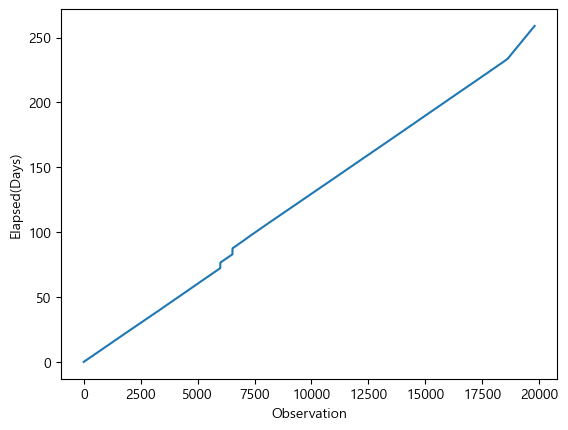

In [28]:
plt.plot(np.array(elapsed)/dt.timedelta(days = 1)) #Elapsed 항목을 일(Day)로 변환
plt.xlabel('Observation')
plt.ylabel('Elapsed(Days)')   

# 시작일에서 부터 관측된(약 20000개) Elapsed 시간(약 250일)

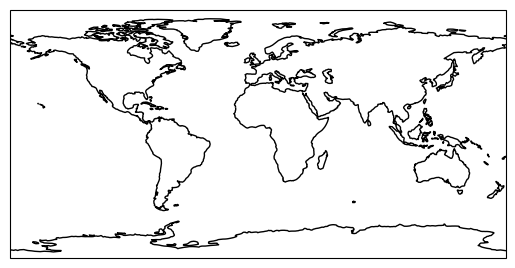

In [30]:
# Plate Carree 투영법으로 지도 생성(지구를 평면으로 투영)
ax = plt.axes(projection = ccrs.PlateCarree())
ax.coastlines() #지도에 해안선 추가
plt.show()

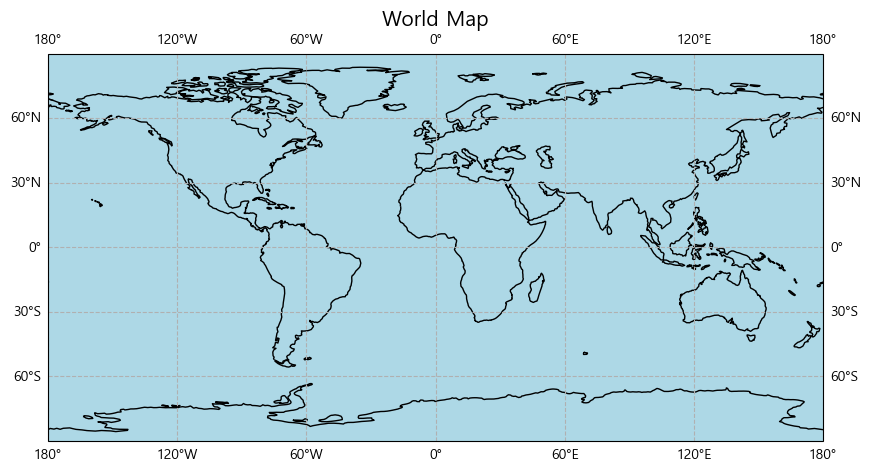

In [33]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree())

ax.set_facecolor('lightblue')
ax.coastlines()

ax.gridlines(draw_labels = True, linestyle = '--')

ax.set_xlabel('Longitude', fontsize = 12)
ax.set_ylabel('Latitude', fontsize = 12)

plt.title('World Map', fontsize = 15)

plt.show()

In [34]:
## Mercator 투영법을 사용하여 위경도 좌표계의 지도를 시각화
## 설정된 영역 내에 육지, 바다, 해안선, 국경선이 표시
## 지구 표면을 원통 표면에 투사하여 표현하는 방법
## 주로 해양 항법에서 사용

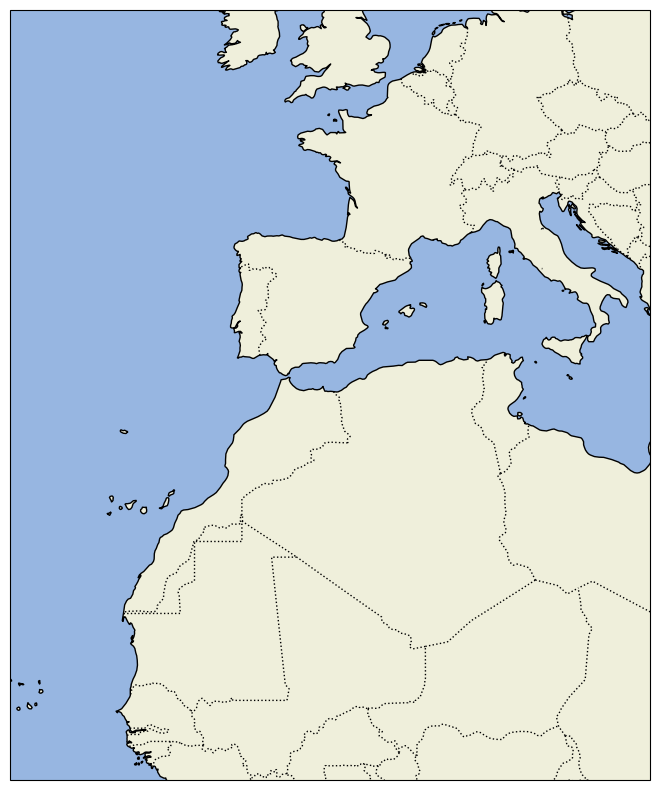

In [38]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection = ccrs.Mercator())
ax.set_extent((-25.0,20.0,52.0,10.0)) #(경도 , 위도  범위 설정)
ax.add_feature(cfeature.LAND) #육지추가
ax.add_feature(cfeature.OCEAN) #바다추가
ax.add_feature(cfeature.COASTLINE) #해안선추가
ax.add_feature(cfeature.BORDERS, linestyle = ':'); #국경선추가
ax.add_feature(cfeature.LAND)

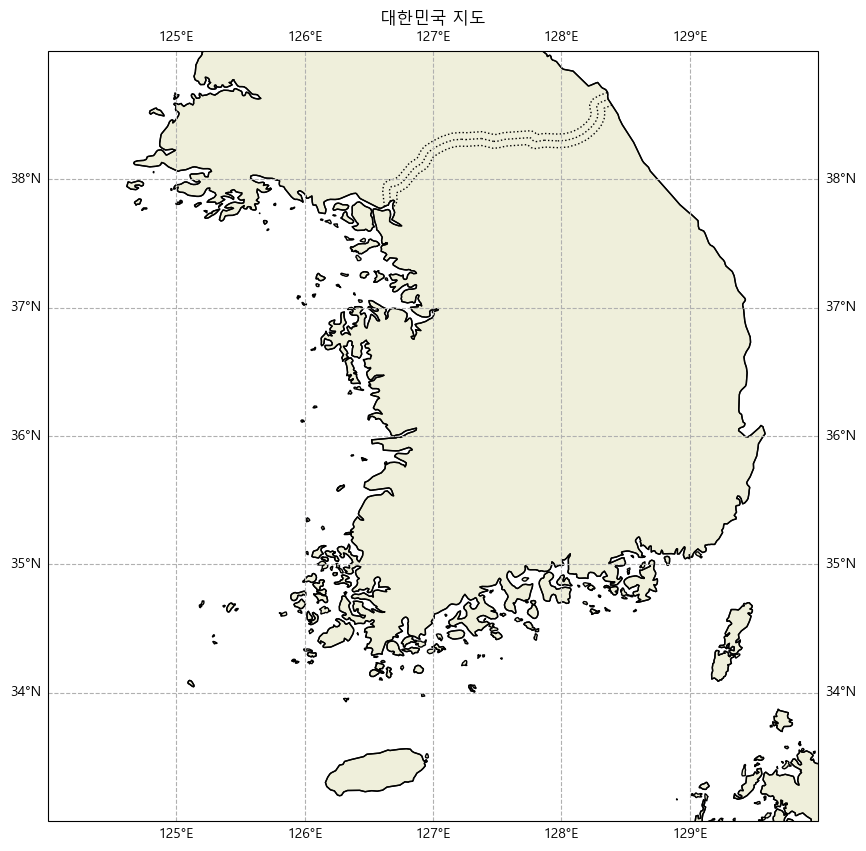

In [40]:
######### 대한민국 지도

extent = [124, 130, 33, 39]

# 지도 생성
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)

# 배경 지도 추가
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')

# 그리드 라인 및 레이블 추가
ax.gridlines(draw_labels=True, linestyle='--')

# 타이틀 추가
plt.title('대한민국 지도')

# 플롯 보이기
plt.show()

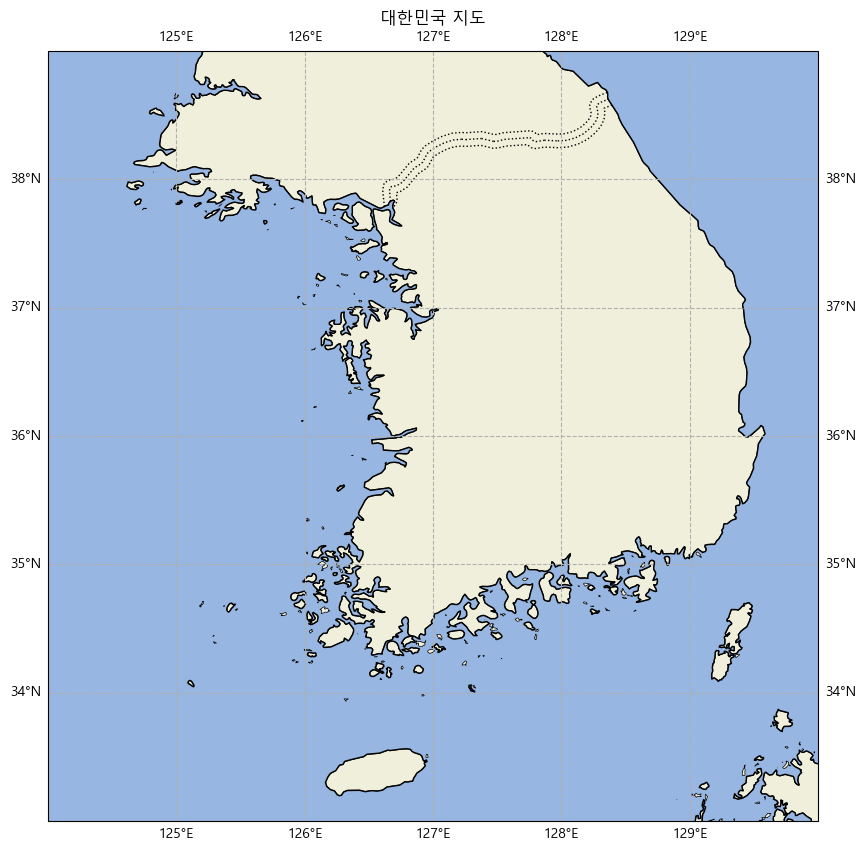

In [42]:
######### 대한민국 지도

extent = [124, 130, 33, 39]

# 지도 생성
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)

# 배경 지도 추가
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN) #해안 추가

# 그리드 라인 및 레이블 추가
ax.gridlines(draw_labels=True, linestyle='--')

# 타이틀 추가
plt.title('대한민국 지도')

# 플롯 보이기
plt.show()

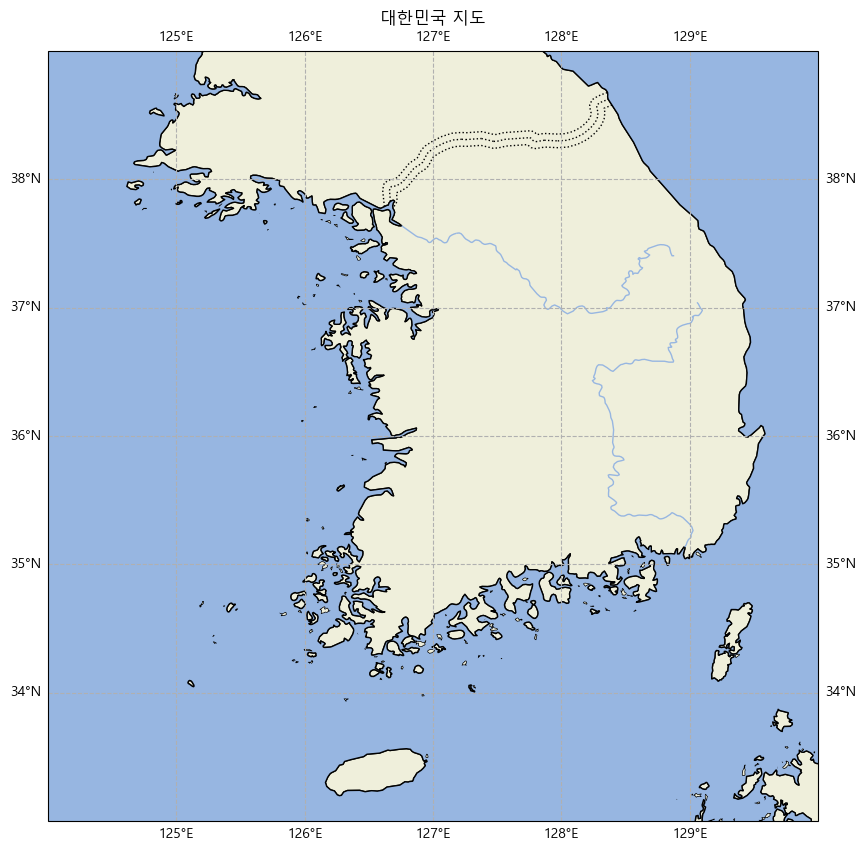

In [43]:

extent = [124, 130, 33, 39]

# 지도 생성
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)

# 배경 지도 추가
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS) #강 추가

# 그리드 라인 및 레이블 추가
ax.gridlines(draw_labels=True, linestyle='--')

# 타이틀 추가
plt.title('대한민국 지도')

# 플롯 보이기
plt.show()

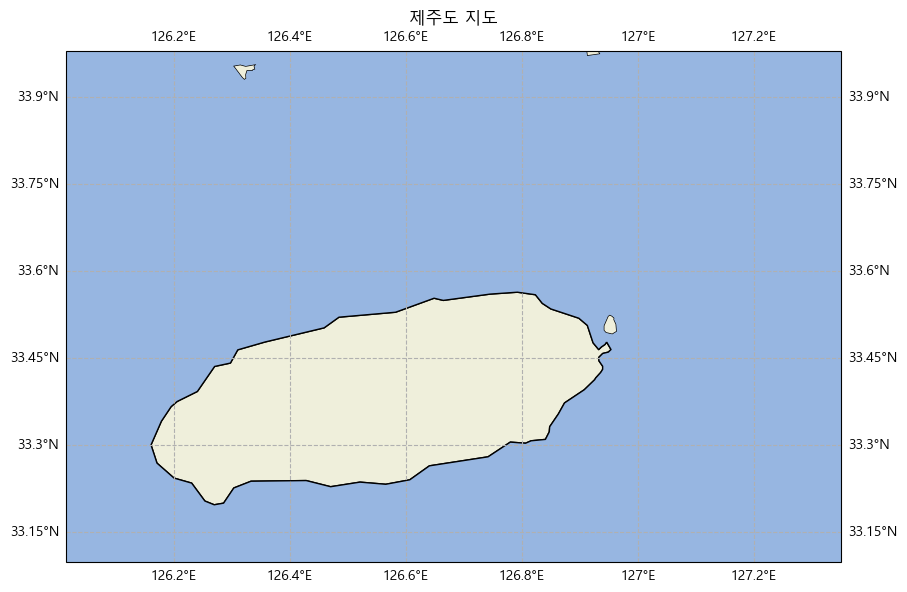

In [45]:
extent = [126.0152, 127.3504, 33.0989, 33.9799]

# 지도 생성
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)

# 배경 지도 추가
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS) #강 추가

# 그리드 라인 및 레이블 추가
ax.gridlines(draw_labels=True, linestyle='--')

# 타이틀 추가
plt.title('제주도 지도')

# 플롯 보이기
plt.show()

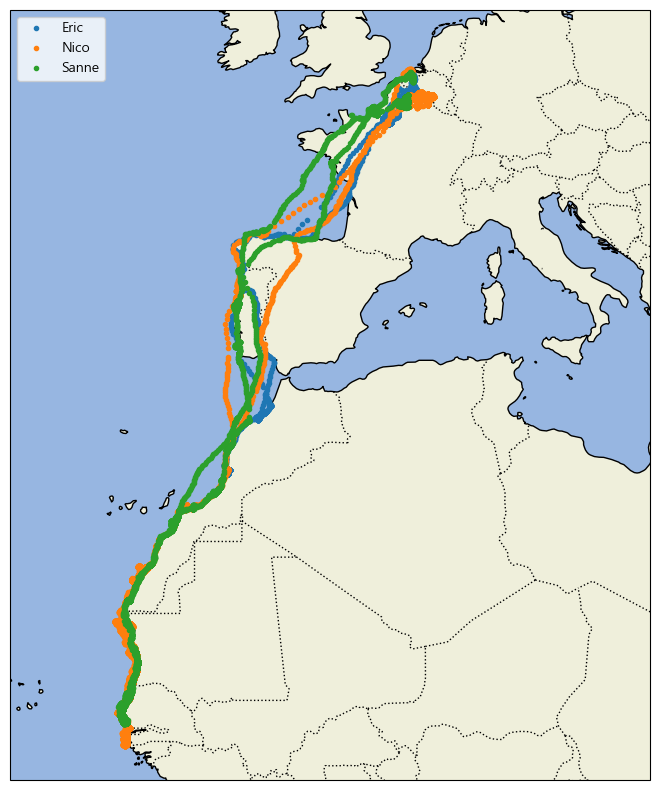

In [49]:
## Mercator 투영법을 이용하여 지도위에 철새이동경로 표시

extent = [-25.0,20.0,52.0,10.0]

# 지도 생성
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent(extent)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

for name in bird_names :
    ix = birdata['bird_name'] == name
    x, y = birdata.longitude[ix], birdata.latitude[ix]
    ax.plot(x, y, '.', transform = ccrs.Geodetic(), label = name)
    
plt.legend(loc = 'upper left')

# transform-ccrs.Geodetic() : 경도및 위도 좌표를 지도 좌표러 변환
